# class building - wifi traffic analyzer

In [150]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook, tnrange, trange, tqdm
from itertools import cycle
from collections import Counter
from pathlib import Path
import time

import altair as alt
from altair.expr import datum

## configs

In [13]:
real_data_path_dict = {
    'real_2': Path(r'data/wifitrafficstats2.csv'),
    'real_3': Path(r'data/wifitrafficstats3.csv'),
    'real_4': Path(r'data/wifitrafficstats4.csv'),
    'real_5': Path(r'data/wifitrafficstats5.csv'),
    'real_6': Path(r'data/wifitrafficstats6.csv')
}

transition_matrics_path_dict = {
    'tmat_1': Path(r'data/wifi_t_matrices.csv'),
    'tmat_2': Path(r'data/wifi_t_matrices2.csv')
}

## class `WifiTrafficAnalyzer`

In [170]:
class WifiTrafficAnalyzer:
    def __init__(self, mode, path_dict): 
        print('initializing..')
        
        # set mode
        mode_options = ['sim','real']
        self.mode = mode.strip().lower()
        assert self.mode in mode_options, \
            f'error: invalid mode {self.mode}, options are {mode_options}'
        
        # load path dict
        self.path_dict = path_dict
        for path in self.path_dict.values():
            try:
                assert path.exists()
            except AssertionError:
                print(f'no file found at path: {path}')
        
        print(f'initialization complete, mode: {self.mode}')
        print(f'{self.mode} data options: ')
        for key, path in self.path_dict.items():
                print(f'\tkey: {key}, path: {path}')
        
        
    
    #------------------------------ real data ------------------------------
    def process_real_data(self, tar_key):
        '''
        takes csv of recorded wifi traffic (identified by key) and stores 
        a dataframe ready to be turned into data list ([1,1,1,0,0,1,1,0,0,0])
        '''
        # validate target file selection
        try:
            assert tar_key in self.path_dict.keys()
        except AssertionError:
            print(f'invalid key {tar_key}, options are {list(self.path_dict.keys())}')
            
        real_df = (
            pd
            .read_csv(self.path_dict[tar_key])
            .rename({ 
                'Time':'time', 
                'Length':'length', 
                'TX Rate':'rate'
            }, axis=1)
            .eval('time = time * 1e6')
            .eval('rate = rate * 1e6')
            .eval('length = length * 8')
            .eval('on_time = 1e6 * length / rate')
            .eval('end_time = time + on_time')
            .assign(
                shift_time = lambda x: x.end_time.shift(1),
                off_time = lambda x: [
                    (time - shift_time) 
                        if (time - shift_time) > 0 else 0 
                    for time, shift_time in (zip(x.time, x.shift_time))
            ])
            .drop(['No.','Delta Time','shift_time'], axis=1)
            .round(0)
        )
        
        self.generate_real_data_list(real_df)
    
    
    def generate_real_data_list(self, df):
        '''
        takes dataframe with 'on_time' and 'off_time' time stamp columns 
        and stores a numpy array of 1's (on_time) and 0's (off_time)
        '''
        
        real_data_list = []
    
        for row in tqdm_notebook(df[['on_time','off_time']].iloc[1:].itertuples(), total=df.shape[0]-1):
            real_data_list.extend([1 for i in range(int(row.on_time))])
            real_data_list.extend([0 for i in range(int(row.off_time))])
        
        self.real_data_array = np.array(real_data_list, copy=True)
        
    
    #------------------------------ sim data ------------------------------
    def process_transition_matrices(self, tar_key):
        # validate target file selection
        try:
            assert tar_key in self.path_dict.keys()
        except AssertionError:
            print(f'invalid key {tar_key}, options are {list(self.path_dict.keys())}')
        
        
        self.tmat_df = (
            pd
            .read_csv(
                self.path_dict[tar_key], 
                names=['OnOn','OnOff','OffOn','OffOff','timestep']
            )
            #.eval('OffOff = 1 - OffOff')
            #.eval('OffOn = 1 - OffOn')
            [['OnOn', 'OnOff', 'OffOff', 'OffOn', 'timestep']]
        )
        
    
    
    def generate_sim_data(self, n_samples, m_trials, transition_matrix):
        '''
        takes a transition matrix and generates a simulated signal
        with <n_samples> bits and <m_trials> trials, stores an n x m 
        matrix
        '''
            
        cycle_dict = {
            (1,1,1): 0,
            (1,1,0): 1,
            (1,0,1): 2,
            (1,0,0): 1,
            (0,1,1): 1,
            (0,1,0): 2,
            (0,0,1): 1,
            (0,0,0): 0,
        }
        
        global p
        p = 0.5
        sim_matrix = np.zeros((int(m_trials), int(n_samples)))        
        state_cycler = cycle(transition_matrix)
        
        def cycle_states():
            return next(state_cycler)
        
        def generate_bit(n):
            global p
            
            if n == 0:
                return np.random.binomial(1, p)
                
            else:
                for i in range(n):
                    p = cycle_states()
    
                return np.random.binomial(1, p)
            
        for i in tnrange(m_trials, leave=False):
            sim_data = [1,1,1]
            p = 0.5
            
            for _ in range(n_samples + 1):        
                new_bit = generate_bit(cycle_dict[tuple(sim_data[-3:])])        
                sim_data.append(new_bit)
                
            sim_matrix[i,:] = np.array(sim_data[4:])
        
        return sim_matrix
    
        
    def simulate_all_transition_matrices(self, n_samples=int(1e5), m_trials=10):
        start_time = time.time()

        self.stats_dict = self.master_dictionary = {
            row.timestep: {}
            for row in self.tmat_df.itertuples()
        }
        
        for row in tqdm_notebook(self.tmat_df.itertuples(), total=self.tmat_df.shape[0]):
            transition_matrix = [row.OnOn, row.OnOff, row.OffOff, row.OffOn]
            sim_matrix = self.generate_sim_data(n_samples, m_trials, transition_matrix)    
            
            self.master_dictionary[row.timestep] = self.compute_sim_stats(sim_matrix)            

            
        print(f'total elapsed time: {(time.time() - start_time)/60:0.2f} minutes')
        
        self.post_process_stats()
    
    
    
    def compute_sim_stats(self, sim_matrix):
        sample_size = sim_matrix.shape[1]
        stats = sim_matrix.sum(axis=1)
                        
        state_lengths_0 = [
            item for sublist in
            [
                list(self.get_split_state_lengths(sim_matrix[i,:])[0])
                for i in range(sim_matrix.shape[0])
            ]
            for item in sublist
        ]
        
        state_lengths_1 = [
            item for sublist in
            [
                list(self.get_split_state_lengths(sim_matrix[i,:])[1])
                for i in range(sim_matrix.shape[0])
            ]
            for item in sublist
        ]
        
        return {
            'mean': np.mean(stats) / sample_size,
            'std': np.std(stats) / sample_size,
            'state_lengths_0': Counter(state_lengths_0).most_common(),
            'state_lengths_1': Counter(state_lengths_1).most_common()
        }
    
    def post_process_stats(self):
        '''
        takes previously computed self.master_dictionary and splits it into two dataframes
            full_df: duration, frequency, bit, timestep for all simulations
            stats_df: mean and std of m_trials
        '''
        
        self.df_dict_0 = {
            tstep: (
                pd.DataFrame(
                    stats['state_lengths_0'], 
                    columns=['duration','frequency']
                )
                .sort_values('duration')
                .reset_index(drop=True)
                .assign(
                    timestep = tstep,
                    bit = 0
                )
            )
            for tstep, stats in self.master_dictionary.items()
        }
        
        self.df_dict_1 = {
            tstep: (
                pd.DataFrame(
                    stats['state_lengths_1'], 
                    columns=['duration','frequency']
                )
                .sort_values('duration')
                .reset_index(drop=True)
                .assign(
                    timestep = tstep,
                    bit = 1
                )
            )
            for tstep, stats in self.master_dictionary.items()
        }
        
        self.full_sim_df = pd.concat(
            [df for df in WTA.df_dict_0.values()] + [df for df in WTA.df_dict_1.values()]
        )
        
        stats_list = [
            {
                'timestep': timestep,
                'mean': stats['mean'],
                'std': stats['std']
            }
            for timestep, stats in self.master_dictionary.items()
        ]
        
        self.stats_df = pd.DataFrame(stats_list)[['timestep','mean','std']]
    
    
    
    #------------------------------ common functions ------------------------------
    def get_split_state_lengths(self, data):
        '''
        takes data list ([1,1,0,1,0,0,...]) and returns separate
        numpy arrays of duration of consecutive bits ([13,245,2588,19,1056,...])
        for 1's and for 0's
        '''
        
        data = np.array(data)    
        
        state_lengths = np.diff(
            np.where(
                np.concatenate(
                    ([data[0]],
                     data[:-1] != data[1:],
                     [0]
                    )
                )
            )[0]
        )[::2]
        
        # split
        if data[0] == 0:
            data_0 = state_lengths[0::2]
            data_1 = state_lengths[1::2]
        else:
            data_0 = state_lengths[1::2]
            data_1 = state_lengths[0::2]
            
        return data_0, data_1
    
    
    #------------------------------ visualization ------------------------------
    
    def state_length_vs_timestep_sim(self, full_sim_df, chart_type='bar', background_color='#abb2bf'):
        '''
        creates interactive charts showing distributions of on and off times for simulated data
        
        chart types:
            bar: bar chart (histogram)
            area: area chart (filled line chart)
            
        background_color:
            hex code for chart background color, ex:
                #abb2bf - grey
                #ffffff - white
        '''
        
        chart_type = chart_type.strip().lower()

        sel_timestep = alt.selection_multi(encodings=['y'])
        
        bar_chart = alt.Chart(
            full_sim_df,
            height=800,
            width=250
        ).mark_bar(
        ).encode(
            alt.X(
                'max(duration):Q',
                title='max packet duration',
                scale=alt.Scale(type='log')
            ),
            alt.Y(
                'timestep:N',
            ),
            color=alt.condition(
                sel_timestep,
                'timestep:N',
                alt.value('#96989b'),
                legend=None
            ),
            tooltip = [
                alt.Tooltip('')
            ]
        ).add_selection(
            sel_timestep
        )        
        
        detail_bar_chart = alt.Chart(
            full_sim_df,
            height=375,
            width=800
        ).mark_bar(
            opacity=0.5
        ).transform_filter(
            sel_timestep
        ).transform_filter(
            datum.duration > 25
        ).transform_filter(
            datum.duration < 200
        ).encode(
            alt.X('duration:Q'),
            alt.Y(
                'frequency:Q', 
                #scale=alt.Scale(type='log')
            ),
            color=alt.Color('timestep:N', legend=None),
            tooltip=[
                alt.Tooltip('duration:Q'),
                alt.Tooltip('frequency:Q'),
                alt.Tooltip('timestep:N'),
                alt.Tooltip('bit:N'),
            ]
        )
        
        detail_area_chart = alt.Chart(
            full_sim_df,
            height=375,
            width=800
        ).mark_area(
            opacity=0.5
        ).transform_filter(
            sel_timestep
        ).transform_filter(
            datum.duration > 25
        ).transform_filter(
            datum.duration < 200
        ).encode(
            alt.X('duration:Q'),
            alt.Y(
                'frequency:Q', 
                #scale=alt.Scale(type='log')
            ),
            color=alt.Color('timestep:N', legend=None),
            tooltip=[
                alt.Tooltip('duration:Q'),
                alt.Tooltip('frequency:Q'),
                alt.Tooltip('timestep:N'),
                alt.Tooltip('bit:N'),
            ]
        )
        
        if chart_type == 'bar':
            detail_chart = detail_bar_chart
        elif chart_type == 'area':
            detail_chart = detail_area_chart
        else:
            print(f'unsupported chart type {chart_type}')
        
        stacked_bit_details = alt.vconcat(
            detail_chart.transform_filter(datum.bit == 0).properties(title='off time distributions'),
            detail_chart.transform_filter(datum.bit == 1).properties(title='on time distributions'),
        )
        
        full = alt.hconcat(
            bar_chart,
            stacked_bit_details,    
            background=background_color
        )
        
        display(full)
    
        
    
    
    
    
        
        
        

#### sim data mode

In [171]:
WTA = WifiTrafficAnalyzer(mode='sim', path_dict=transition_matrics_path_dict)

initializing..
initialization complete, mode: sim
sim data options: 
	key: tmat_1, path: data\wifi_t_matrices.csv
	key: tmat_2, path: data\wifi_t_matrices2.csv


In [172]:
WTA.process_transition_matrices('tmat_2')
WTA.simulate_all_transition_matrices()


total elapsed time: 0.84 minutes


In [ ]:
WTA.state_length_vs_timestep_sim(WTA.full_sim_df, chart_type='bar')

In [ ]:
WTA.state_length_vs_timestep_sim(WTA.full_sim_df, chart_type='area')

#### real data mode

In [79]:
WTA = WifiTrafficAnalyzer(mode='real', path_dict=real_data_path_dict)

initializing..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv


In [70]:
WTA.process_real_data('real_2')

In [71]:
WTA.get_split_state_lengths(WTA.real_data_array)

(array([  13, 2105,   13, ...,   13,   19,   13], dtype=int64),
 array([  13, 2288,   13, ...,   11,    5, 1097], dtype=int64))

## visualization dev

In [153]:
full_sim_df = WTA.full_df

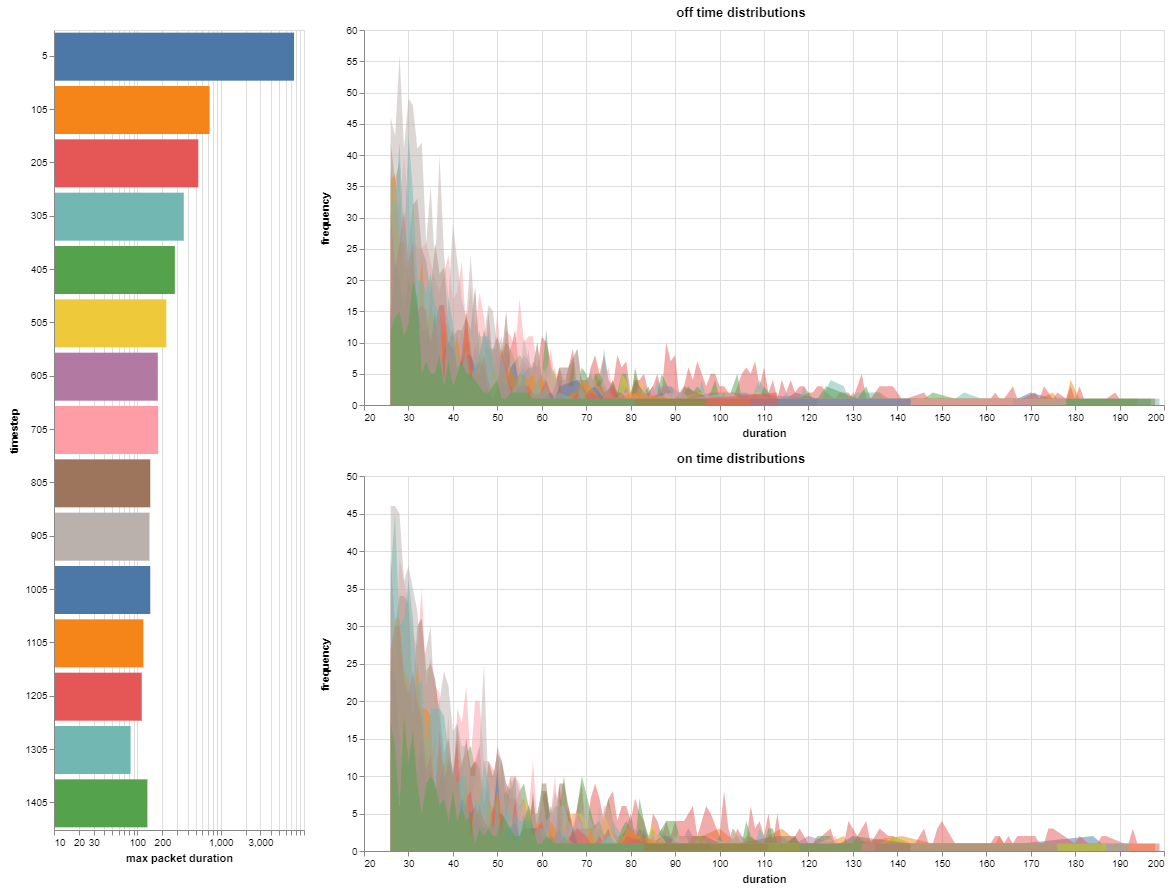

In [169]:
chart_type = chart_type.strip().lower()

sel_timestep = alt.selection_multi(encodings=['y'])

bar_chart = alt.Chart(
    full_sim_df,
    height=800,
    width=250
).mark_bar(
).encode(
    alt.X(
        'max(duration):Q',
        title='max packet duration',
        scale=alt.Scale(type='log')
    ),
    alt.Y(
        'timestep:N',
    ),
    color=alt.condition(
        sel_timestep,
        'timestep:N',
        alt.value('#96989b'),
        legend=None
    )
).add_selection(
    sel_timestep
)        

detail_bar_chart = alt.Chart(
    full_sim_df,
    height=375,
    width=800
).mark_bar(
    opacity=0.5
).transform_filter(
    sel_timestep
).transform_filter(
    datum.duration > 25
).transform_filter(
    datum.duration < 200
).encode(
    alt.X('duration:Q'),
    alt.Y(
        'frequency:Q', 
        #scale=alt.Scale(type='log')
    ),
    color=alt.Color('timestep:N', legend=None),
    tooltip=[
        alt.Tooltip('duration:Q'),
        alt.Tooltip('frequency:Q'),
        alt.Tooltip('timestep:N'),
        alt.Tooltip('bit:N'),
    ]
)

detail_area_chart = alt.Chart(
    full_sim_df,
    height=375,
    width=800
).mark_area(
    opacity=0.5
).transform_filter(
    sel_timestep
).transform_filter(
    datum.duration > 25
).transform_filter(
    datum.duration < 200
).encode(
    alt.X('duration:Q'),
    alt.Y(
        'frequency:Q', 
        #scale=alt.Scale(type='log')
    ),
    color=alt.Color('timestep:N', legend=None),
    tooltip=[
        alt.Tooltip('duration:Q'),
        alt.Tooltip('frequency:Q'),
        alt.Tooltip('timestep:N'),
        alt.Tooltip('bit:N'),
    ]
)

if chart_type == 'bar':
    detail_chart = detail_bar_chart
elif chart_type == 'area':
    detail_chart = detail_area_chart
else:
    print(f'unsupported chart type {chart_type}')

stacked_bit_details = alt.vconcat(
    detail_chart.transform_filter(datum.bit == 0).properties(title='off time distributions'),
    detail_chart.transform_filter(datum.bit == 1).properties(title='on time distributions'),
)

full = alt.hconcat(
    bar_chart,
    stacked_bit_details,    
    background='#ffffff'
)

display(full)